# Grid Topology Generation

This notebook demonstrates how to artificially generate a power grid topology. We consider the so-called Chung-Lu-Chain graph model, and refer to [Aksoy et al. (2018)](https://academic.oup.com/comnet/article-abstract/7/1/128/5073058?redirectedFrom=fulltext).

## Basics

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

from powergrid_synth.generator import PowerGridGenerator
from powergrid_synth.input_configurator import InputConfigurator
from powergrid_synth.hierarchical_analysis import HierarchicalAnalyzer
from powergrid_synth.visualization import GridVisualizer

## CLC topology generation
We consider a Chung-Lu-Chain graph model for the grid topology generation. It contains two phases:

- **Phase 1**: For each the same-voltage subgraph, we consider the Chung-Lu-Chain model that takes as input __the desired node degree sequence__ and __the desired graph diameter__. 

- **Phase 2**: After the same-voltage subgraphs are created, transformer edges between each pair of subgraphs are inserted. This takes as input **the desired transformer degree of each vertex in the subgraphs of voltage** $X$ and $Y$. 


### Two operation modes
1. _Mode I:_ When using the CLC graph generation model, one requires __desired same-voltage subgraph degrees and diameter__ for Phase 1, and __desired transformer degrees__ for Phase 2. They can be easily extracted from given (realistic) power grid topology. We can refer to this as __Operation mode I__ --- one can fit the model to existing power grid graphs and create ensembles of structurally similar graphs. 

2. _Mode II:_ In cases where real-world grid data is completely unavailable or when users want to scale or vary the inputs, we would prefer to use _ONLY_ artificial input. This __Opertaion mode II__ requires users only specifying the number of vertices in each same-voltage subgraph. Then, one would need to generate the artificial degree sequences and transformer degrees in some way, e.g., statistically using some __degree distributions__ or __fitting functions__.
    - In this mode, users are free to decide which assumptions are most appropriate for their purposes. 
    - In this project, we consider some statistically-significant fitting functions and distributions to generate the needed input. 

In [2]:
# Define 3 voltage levels
level_specs = [
    # Level 0
    {'n': 20, 'avg_k': 4.0, 'diam': 6, 'dist_type': 'dgln'},
    # Level 1
    {'n': 20, 'avg_k': 3.0, 'diam': 10, 'dist_type': 'dpl'},
    # Level 2
    {'n': 10, 'avg_k': 2.0, 'diam': 10, 'dist_type': 'dgln'}
]

connection_specs = {
    (0, 1): {'type': 'k-stars', 'c': 0.174, 'gamma': 4.15},
    (1, 2): {'type': 'k-stars', 'c': 0.15, 'gamma': 4.15}
}

### Define an input configurator
It configurates the input parameters to the needed ones for the algorithm

In [3]:
# Initialize Configurator
configurator = InputConfigurator(seed=100)

# Generating Input Parameters
params = configurator.create_params(level_specs, connection_specs)


Generating Level 0: DGLN distribution (Avg=4.0)
Generating Level 1: DPL distribution (Avg=3.0)
Generating Level 2: DGLN distribution (Avg=2.0)
Generating Transformers 0<->1: k-Stars Model
4.15
Generating Transformers 1<->2: k-Stars Model
4.15


### Generate the grid topology

In [4]:
gen = PowerGridGenerator(seed=100)
grid_graph = gen.generate_grid(
    degrees_by_level=params['degrees_by_level'],
    diameters_by_level=params['diameters_by_level'],
    transformer_degrees=params['transformer_degrees'], 
    keep_lcc=True, # only keep the largest connected component
)

--- Starting Generation for 3 Voltage Levels ---
Generating Level 0...
  -> Level 0 Complete. Nodes: 21, Edges: 28
Generating Level 1...
  -> Level 1 Complete. Nodes: 26, Edges: 20
Generating Level 2...
  -> Level 2 Complete. Nodes: 12, Edges: 11
Generating Transformer Connections...
  -> Connecting Level 0 <-> Level 1
  -> Connecting Level 1 <-> Level 2
Filtering for Largest Connected Component (LCC)...
  -> Kept 52 nodes (removed 7 isolated nodes).


### Visualize the generated grid

In [5]:
viz = GridVisualizer()


--- Visualizing Full Grid (non-Interactive Mode) ---
Calculating layout 'kamada_kawai'...


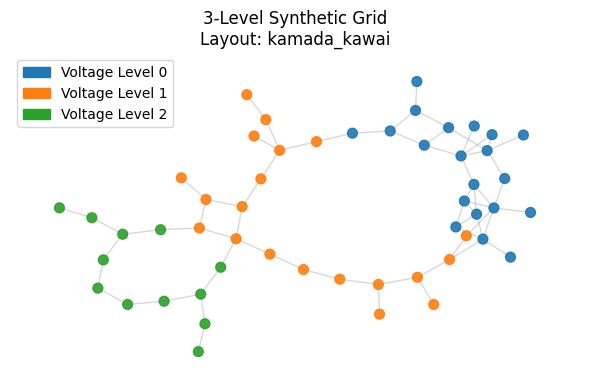

In [6]:
print("\n--- Visualizing Full Grid (non-Interactive Mode) ---")
viz.plot_grid(
    grid_graph, 
    layout='kamada_kawai',
    title="3-Level Synthetic Grid",
    figsize=(6, 4)
)

In [7]:
sub_lv0 = grid_graph.level(0)
sub_lv1 = grid_graph.level(1)

Calculating layout 'kamada_kawai'...
Calculating layout 'kamada_kawai'...
Calculating layout 'kamada_kawai'...


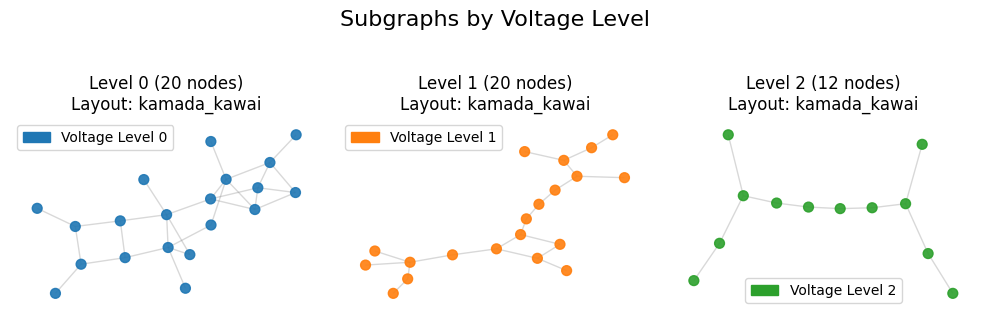

In [8]:
viz.plot_subgraphs(grid_graph, figsize=(10,3))

### Analyze the generated topology

Grid Generated: 52 nodes, 64 edges

--- Running Hierarchical Analysis ---

GLOBAL GRID ANALYSIS

=== Power Grid Topological Analysis ===
Nodes: 52
Edges: 64
Density: 0.048265
Connected: Yes
Diameter: 15
Avg Shortest Path Length: 6.6523
Avg Local Clustering Coeff: 0.0647

Plotting Global Degree Distribution...


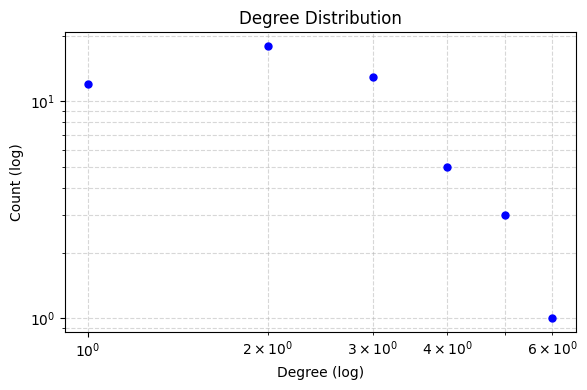


ANALYSIS FOR VOLTAGE LEVEL 0

=== Power Grid Topological Analysis ===
Nodes: 20
Edges: 28
Density: 0.147368
Connected: Yes
Diameter: 7
Avg Shortest Path Length: 3.1105
Avg Local Clustering Coeff: 0.1733


ANALYSIS FOR VOLTAGE LEVEL 1

=== Power Grid Topological Analysis ===
Nodes: 20
Edges: 20
Density: 0.105263
Connected: Yes
Diameter: 12
Avg Shortest Path Length: 4.9895
Avg Local Clustering Coeff: 0.0000


ANALYSIS FOR VOLTAGE LEVEL 2

=== Power Grid Topological Analysis ===
Nodes: 12
Edges: 11
Density: 0.166667
Connected: Yes
Diameter: 9
Avg Shortest Path Length: 3.8485
Avg Local Clustering Coeff: 0.0000

Plotting Combined Figure for 3 Levels (Log Scale: True)...


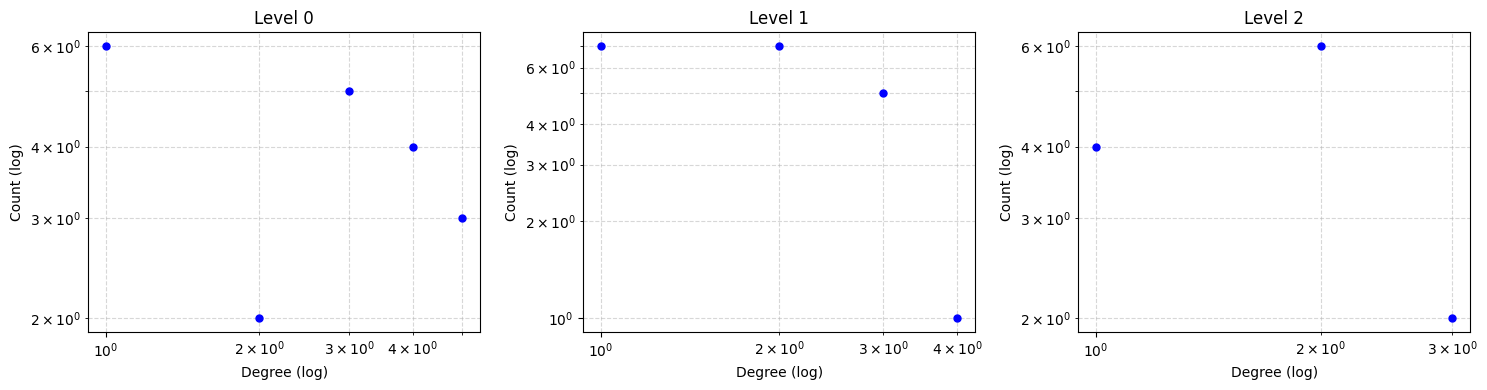

Analysis Complete.


In [9]:
print(f"Grid Generated: {grid_graph.number_of_nodes()} nodes, {grid_graph.number_of_edges()} edges")

print("\n--- Running Hierarchical Analysis ---")

# Initialize the Analyzer
analyzer = HierarchicalAnalyzer(grid_graph)

# Run the full report
# - Calculates global metrics (Diameter, Clustering, etc.)
# - Calculates metrics for EACH voltage level subgraph
# - Plots degree distributions (Log-Log scale)
analyzer.run_full_report(log_scale=True)

print("Analysis Complete.")